In [1]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import math
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



In [2]:
df = pd.read_csv('../cleaned_data.csv', sep=';')

# --- 1) ensure numeric price and clean text ---
df['price_pln'] = pd.to_numeric(
    df['price_pln'].astype(str).str.replace(r'[^0-9\.-]', '', regex=True),
    errors='coerce'
)

df['description'] = df['description'].astype(str).fillna('').str.strip()

# drop rows missing price or description
df = df[df['price_pln'].notna() & (df['description'] != '')].copy()


In [3]:
# --- 2) make 50_000-PLN bins (auto range) ---
step = 50_000
min_price = int(math.floor(df['price_pln'].min() / step) * step)
max_price = int(math.ceil(df['price_pln'].max() / step) * step)
bins = np.arange(min_price, max_price + step, step)  # edges: [min, min+step, ..., max]
print(f"Bins from {min_price} to {max_price} step {step} -> {len(bins)-1} classes")

# assign bin labels (0..n_bins-1)
df['price_bin'] = pd.cut(df['price_pln'], bins=bins, right=False, labels=False)

# drop out-of-range just in case
df = df[df['price_bin'].notna()].copy()
df['price_bin'] = df['price_bin'].astype(int)


Bins from 0 to 65450000 step 50000 -> 1309 classes


In [4]:
# --- 3) remove bins with too few samples for stratified CV ---
min_samples_per_class = 5
counts = df['price_bin'].value_counts()
valid_bins = counts[counts >= min_samples_per_class].index
df = df[df['price_bin'].isin(valid_bins)].copy()
print("Rows after filtering rare bins:", len(df))
print("Number of classes after filtering:", df['price_bin'].nunique())

# If too few rows remain, consider reducing min_samples_per_class or increasing step.


Rows after filtering rare bins: 23080
Number of classes after filtering: 234


In [5]:
# --- 4) train/test split (stratified) ---
X = df['description'].values
y = df['price_bin'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
# --- 5) pipeline (TFIDF ONLY) ---
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=30000,
        ngram_range=(1,2),
        min_df=2
    )),
    ("clf", DecisionTreeClassifier(random_state=42))
])



In [7]:
# --- 6) grid search ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "clf__max_depth": [6, 10, 20, None],
    "clf__min_samples_leaf": [1, 3, 5]
}


grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=2,
    n_jobs=1,        # set to 1 to avoid loky worker issues; change if you have stable multiprocessing
    refit=True
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score (mean accuracy):", grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/jakubkubicki/Desktop/studies_repos/ADM_project/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=  11.7s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=  11.8s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=  11.4s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=  11.2s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=  11.3s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=  11.2s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=  10.9s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=  10.7s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=  10.6s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=  10.6s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=5; total time=  10.6s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=5; total time=  10.4s
[CV] END ..........clf__max_

In [8]:
# --- 7) evaluate on test set ---
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

# Optional: show confusion matrix (may be large)
cm = confusion_matrix(y_test, y_pred)
print(cm)

Test accuracy: 0.6280329289428076
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1800
           1       0.61      0.63      0.62      1254
           2       0.52      0.50      0.51       502
           3       0.53      0.52      0.52       331
           4       0.48      0.51      0.50       144
           5       0.42      0.45      0.43        71
           6       0.63      0.46      0.54        41
           7       0.48      0.44      0.46        36
           8       0.88      0.58      0.70        12
           9       0.20      0.09      0.12        11
          10       1.00      0.50      0.67         4
          11       0.75      0.75      0.75         4
          12       0.29      0.50      0.36         4
          13       0.33      0.50      0.40         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16       0.33      0.50      0.40    

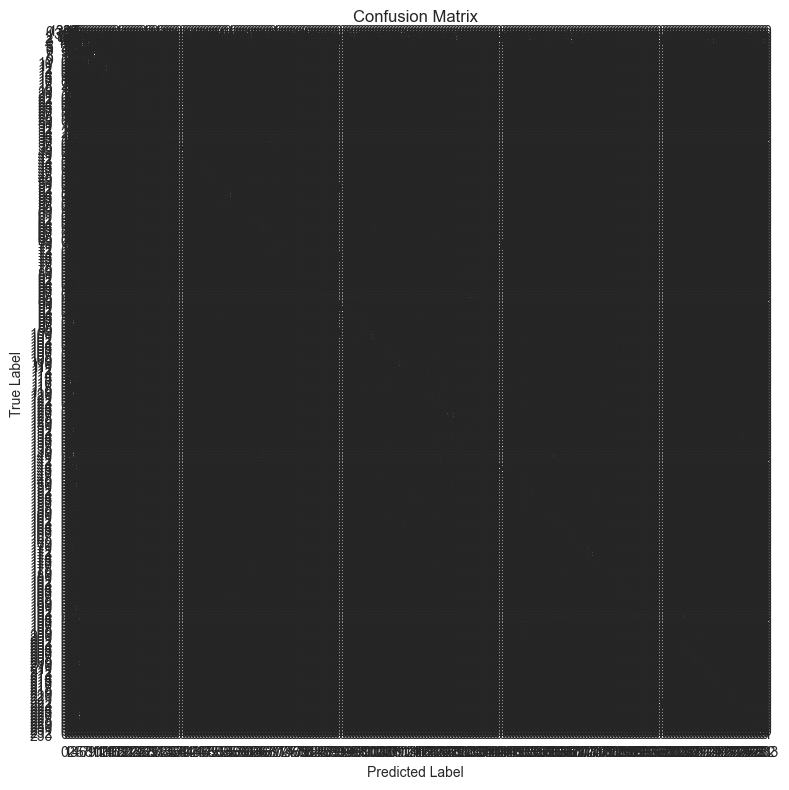

In [9]:

# --- PLOT ---
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# add numbers inside cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center")

# ticks
plt.xticks(np.arange(cm.shape[1]))
plt.yticks(np.arange(cm.shape[0]))

plt.tight_layout()

# save figure
plt.savefig("confusion_matrix.png", dpi=150)

# show plot
plt.show()


In [10]:
# --- 8) helper: convert predicted bin index to price range ---
def bin_to_range(bin_idx):
    low = int(bins[bin_idx])
    high = int(bins[bin_idx+1] - 1)
    return (low, high)

# predict for new descriptions
new_descriptions = ["Excellent condition car, hardly used, my favourite BMW car I've ever had."]
pred_bins = best_model.predict(new_descriptions)
print("Predicted bin indices:", pred_bins)
print("Predicted price ranges:", [bin_to_range(b) for b in pred_bins])


Predicted bin indices: [1]
Predicted price ranges: [(50000, 99999)]


In [11]:
# --- 9) save model if wanted ---
# import joblib
# joblib.dump(best_model, "tfidf_svd_dt_price_classifier.joblib")
